In [75]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
%matplotlib inline

In [76]:
# Importing train and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.shape)
print(test_data.shape)

train_data.head()

(18834, 11)
(8072, 9)


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [77]:
# Target Columns
print(train_data["breed_category"].value_counts().sort_index())
print(train_data["pet_category"].value_counts().sort_index())

0.0    9000
1.0    8357
2.0    1477
Name: breed_category, dtype: int64
0       88
1     7184
2    10621
4      941
Name: pet_category, dtype: int64


In [78]:
# Null Values in training dataset
train_null_values = pd.DataFrame({
    "Null_Values" : train_data.isnull().sum(),
    "Percentage" : 100*train_data.isnull().sum() / train_data.shape[0]
})
train_null_values.sort_values(by="Percentage", ascending = False).head(3)

,Null_Values,Percentage
condition,1477,7.8422
pet_id,0,0.0000
issue_date,0,0.0000


In [79]:
# Null Values in Test Dataset
test_null_values = pd.DataFrame({
    "Null_Values" : test_data.isnull().sum(),
    "Percentage" : 100*test_data.isnull().sum() / test_data.shape[0]
})
test_null_values.sort_values(by="Percentage", ascending = False).head(3)

,Null_Values,Percentage
condition,619,7.668484
pet_id,0,0.000000
issue_date,0,0.000000


In [80]:
# checking whether the pet_id is uniqe or not
print(train_data["pet_id"].nunique() == train_data.shape[0])
print(test_data["pet_id"].nunique() == test_data.shape[0])

True
True


In [81]:
# Checking for any training data records in test data 
len(train_data[train_data["pet_id"].isin(test_data["pet_id"])==True])

0

In [82]:
# Gerting No. of days and month from listing_date and issuing_date

train_data["issue_date"] = pd.to_datetime(train_data["issue_date"],dayfirst=True )
train_data["listing_date"] = pd.to_datetime(train_data["listing_date"], dayfirst=True)

test_data["issue_date"] = pd.to_datetime(test_data["issue_date"], dayfirst=True)
test_data["listing_date"] = pd.to_datetime(test_data["listing_date"], dayfirst=True)

train_data["days"] =  (train_data["listing_date"] - train_data["issue_date"]).dt.days
test_data["days"] =  (test_data["listing_date"] - test_data["issue_date"]).dt.days

train_data["issue_month"] = train_data["issue_date"].dt.month
train_data["listing_month"] = train_data["listing_date"].dt.month

test_data["issue_month"] = test_data["issue_date"].dt.month
test_data["listing_month"] = test_data["listing_date"].dt.month

train_data.drop(labels=["issue_date","listing_date"], axis=1, inplace=True)
test_data.drop(labels=["issue_date","listing_date"], axis=1, inplace=True)


In [83]:
# Getting unique values from each column
columns = ['condition', 'color_type', 'X1','X2', 'breed_category', 'pet_category','length(m)','height(cm)']
for i in np.arange(len(columns)):
    print("Unique Values in column {} is {} ".format(columns[i] ,sorted(train_data[columns[i]].unique())))
    print("\n")

Unique Values in column condition is [0.0, 1.0, 2.0, nan] 


Unique Values in column color_type is ['Agouti', 'Apricot', 'Black', 'Black Brindle', 'Black Smoke', 'Black Tabby', 'Black Tiger', 'Blue', 'Blue Cream', 'Blue Merle', 'Blue Point', 'Blue Smoke', 'Blue Tabby', 'Blue Tick', 'Blue Tiger', 'Brown', 'Brown Brindle', 'Brown Merle', 'Brown Tabby', 'Brown Tiger', 'Buff', 'Calico', 'Calico Point', 'Chocolate', 'Chocolate Point', 'Cream', 'Cream Tabby', 'Fawn', 'Flame Point', 'Gold', 'Gray', 'Gray Tabby', 'Green', 'Lilac Point', 'Liver', 'Liver Tick', 'Lynx Point', 'Orange', 'Orange Tabby', 'Pink', 'Red', 'Red Merle', 'Red Tick', 'Sable', 'Seal Point', 'Silver', 'Silver Lynx Point', 'Silver Tabby', 'Tan', 'Torbie', 'Tortie', 'Tortie Point', 'Tricolor', 'White', 'Yellow', 'Yellow Brindle'] 


Unique Values in column X1 is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 


Unique Values in column X2 is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 


Unique Values in column breed

In [84]:
# Fill NaN Values in condition column
print(train_data['condition'].value_counts().sort_index())
print(test_data['condition'].value_counts().sort_index())
train_data['condition'].fillna(3.0, inplace = True)
test_data['condition'].fillna(3.0, inplace = True)

0.0    6281
1.0    6819
2.0    4257
Name: condition, dtype: int64
0.0    2685
1.0    2928
2.0    1840
Name: condition, dtype: int64


In [85]:
# Length of pet cannot be 0 so replacing 0 with the median value of length column

print("No. of records in training data where length is 0 : ",len(train_data[train_data["length(m)"] ==0]))
print("No. of records in test data where length is 0 :",len(test_data[test_data["length(m)"] ==0]))

train_data["length(m)"].replace({0:train_data["length(m)"].median()}, inplace = True)
test_data["length(m)"].replace({0:test_data["length(m)"].median()}, inplace = True)

No. of records in training data where length is 0 :  93
No. of records in test data where length is 0 : 44


In [86]:
# Converting Height from centimeter to meter
train_data["height(m)"] = train_data["height(cm)"] / 100
test_data["height(m)"] = test_data["height(cm)"] /100

train_data.drop("height(cm)", inplace=True, axis=1)
test_data.drop("height(cm)", inplace=True, axis=1)

In [87]:
train_data["days"] =  np.abs(train_data["days"])
test_data["days"] = np.abs(test_data["days"])

train_data["days"] = np.log1p(train_data["days"])
test_data["days"] = np.log1p(test_data["days"])

train_data["col_1"] = train_data["height(m)"] * train_data["length(m)"]
test_data["col_1"] = test_data["height(m)"] * test_data["length(m)"]

In [88]:
train_data.head()

,pet_id,condition,color_type,length(m),X1,X2,breed_category,pet_category,days,issue_month,listing_month,height(m),col_1
0,ANSL_69903,2.0,Brown Tabby,0.80,13,9,0.0,1,4.304065,7,9,0.0778,0.062240
1,ANSL_66892,1.0,White,0.72,13,9,0.0,2,7.529943,11,12,0.1419,0.102168
2,ANSL_69750,3.0,Brown,0.15,15,4,2.0,4,6.624065,9,10,0.4090,0.061350
3,ANSL_71623,1.0,White,0.62,0,1,0.0,2,6.628041,12,1,0.1782,0.110484
4,ANSL_57969,2.0,Black,0.50,18,4,0.0,1,3.970292,9,11,0.1106,0.055300


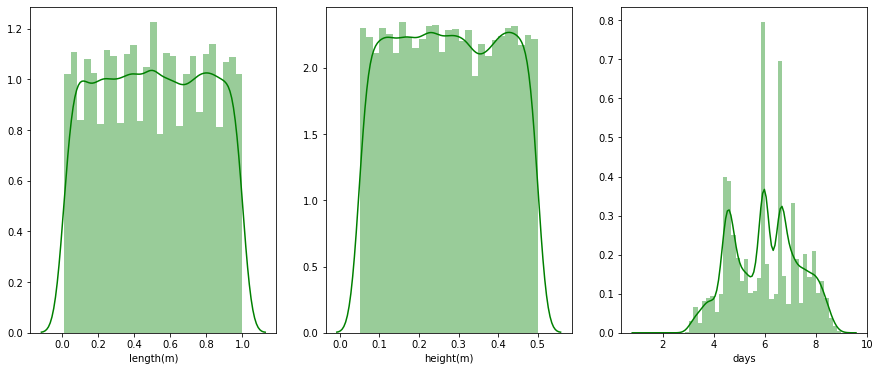

In [89]:
cols = ["length(m)","height(m)","days"]
fig, ax = plt.subplots(1,3,figsize=(15,6),squeeze=False)
for i in np.arange(3):
    sns.distplot(train_data[cols[i]], ax=ax[0][i], color="green")
plt.show()

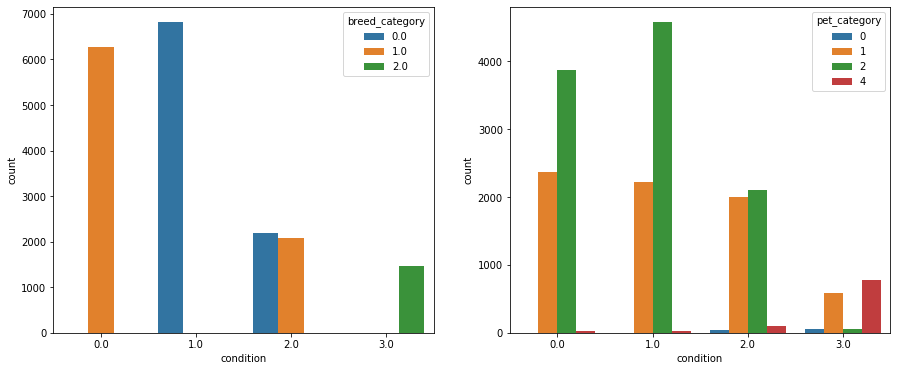

In [90]:
fig, ax = plt.subplots(1,2,figsize=(15,6),squeeze=False)
sns.countplot(x= train_data["condition"], hue=train_data["breed_category"], ax=ax[0][0])
sns.countplot(x= train_data["condition"], hue=train_data["pet_category"], ax=ax[0][1])
plt.show()

In [91]:
# Making Train and test Split
X_train = train_data.drop(labels=["pet_id","breed_category","pet_category"], axis=1)
X_test = test_data.drop(labels=["pet_id"], axis=1)
y_train_breed_category = train_data["breed_category"]
y_train_pet_category = train_data["pet_category"]

print(X_train.shape)
print(X_test.shape)
print(y_train_breed_category.shape)
print(y_train_pet_category.shape)

(18834, 10)
(8072, 10)
(18834,)
(18834,)


# Category Boost

In [92]:
cat_column = ["color_type","X1","X2", "issue_month", "listing_month"]

cat_boost = CatBoostClassifier(n_estimators=230, learning_rate=0.0232558, random_state=101,max_depth=8, 
                              objective="MultiClass") 
cat_boost.fit(X_train,y_train_breed_category, cat_features = cat_column)

training_prediction_breed = cat_boost.predict(X_train)
test_prediction_breed = cat_boost.predict(X_test) 

training_accuracy = f1_score(y_train_breed_category,training_prediction_breed,average="weighted")
print("Training Accuracy ", training_accuracy)

0:	learn: 1.0605731	total: 24.5ms	remaining: 5.61s
1:	learn: 1.0251176	total: 42.2ms	remaining: 4.82s
2:	learn: 0.9917016	total: 55.5ms	remaining: 4.2s
3:	learn: 0.9603669	total: 70.8ms	remaining: 4s
4:	learn: 0.9307279	total: 89.9ms	remaining: 4.04s
5:	learn: 0.9029499	total: 124ms	remaining: 4.63s
6:	learn: 0.8766079	total: 163ms	remaining: 5.18s
7:	learn: 0.8515070	total: 181ms	remaining: 5.02s
8:	learn: 0.8277992	total: 206ms	remaining: 5.05s
9:	learn: 0.8051995	total: 235ms	remaining: 5.18s
10:	learn: 0.7835930	total: 259ms	remaining: 5.17s
11:	learn: 0.7630068	total: 278ms	remaining: 5.05s
12:	learn: 0.7433006	total: 286ms	remaining: 4.77s
13:	learn: 0.7244921	total: 298ms	remaining: 4.6s
14:	learn: 0.7064928	total: 310ms	remaining: 4.45s
15:	learn: 0.6892368	total: 318ms	remaining: 4.25s
16:	learn: 0.6728591	total: 349ms	remaining: 4.37s
17:	learn: 0.6573418	total: 380ms	remaining: 4.47s
18:	learn: 0.6421585	total: 402ms	remaining: 4.46s
19:	learn: 0.6275716	total: 434ms	remaini

161:	learn: 0.1658391	total: 4.38s	remaining: 1.84s
162:	learn: 0.1655072	total: 4.43s	remaining: 1.82s
163:	learn: 0.1652482	total: 4.47s	remaining: 1.8s
164:	learn: 0.1650711	total: 4.51s	remaining: 1.78s
165:	learn: 0.1648034	total: 4.56s	remaining: 1.76s
166:	learn: 0.1644722	total: 4.6s	remaining: 1.74s
167:	learn: 0.1642386	total: 4.64s	remaining: 1.71s
168:	learn: 0.1640397	total: 4.68s	remaining: 1.69s
169:	learn: 0.1637710	total: 4.72s	remaining: 1.67s
170:	learn: 0.1635406	total: 4.76s	remaining: 1.64s
171:	learn: 0.1633282	total: 4.81s	remaining: 1.62s
172:	learn: 0.1631664	total: 4.84s	remaining: 1.59s
173:	learn: 0.1629721	total: 4.89s	remaining: 1.57s
174:	learn: 0.1627400	total: 4.92s	remaining: 1.55s
175:	learn: 0.1625284	total: 4.96s	remaining: 1.52s
176:	learn: 0.1623404	total: 5.01s	remaining: 1.5s
177:	learn: 0.1621768	total: 5.04s	remaining: 1.47s
178:	learn: 0.1620344	total: 5.08s	remaining: 1.45s
179:	learn: 0.1617505	total: 5.12s	remaining: 1.42s
180:	learn: 0.1

In [93]:
cat_column = ["color_type","X1","X2", "issue_month", "listing_month"]

cat_boost = CatBoostClassifier(n_estimators=475, learning_rate=0.05 ,random_state=101,max_depth=8,
                              objective="MultiClass") 
cat_boost.fit(X_train,y_train_pet_category, cat_features = cat_column)

training_prediction_pet = cat_boost.predict(X_train)
test_prediction_pet = cat_boost.predict(X_test) 

training_accuracy = f1_score(y_train_pet_category,training_prediction_pet,average="weighted")
print("Training Accuracy ", training_accuracy)

0:	learn: 1.2772443	total: 57.1ms	remaining: 27.1s
1:	learn: 1.1868892	total: 112ms	remaining: 26.6s
2:	learn: 1.1084811	total: 160ms	remaining: 25.2s
3:	learn: 1.0393406	total: 206ms	remaining: 24.2s
4:	learn: 0.9803087	total: 232ms	remaining: 21.8s
5:	learn: 0.9254309	total: 297ms	remaining: 23.2s
6:	learn: 0.8764892	total: 338ms	remaining: 22.6s
7:	learn: 0.8326511	total: 388ms	remaining: 22.6s
8:	learn: 0.7931381	total: 433ms	remaining: 22.4s
9:	learn: 0.7577469	total: 486ms	remaining: 22.6s
10:	learn: 0.7258644	total: 533ms	remaining: 22.5s
11:	learn: 0.6957546	total: 583ms	remaining: 22.5s
12:	learn: 0.6675803	total: 638ms	remaining: 22.7s
13:	learn: 0.6431060	total: 668ms	remaining: 22s
14:	learn: 0.6199375	total: 703ms	remaining: 21.6s
15:	learn: 0.5985941	total: 755ms	remaining: 21.7s
16:	learn: 0.5783562	total: 805ms	remaining: 21.7s
17:	learn: 0.5595922	total: 856ms	remaining: 21.7s
18:	learn: 0.5422051	total: 912ms	remaining: 21.9s
19:	learn: 0.5258971	total: 966ms	remainin

161:	learn: 0.2369641	total: 8.34s	remaining: 16.1s
162:	learn: 0.2368056	total: 8.4s	remaining: 16.1s
163:	learn: 0.2366431	total: 8.46s	remaining: 16s
164:	learn: 0.2364309	total: 8.51s	remaining: 16s
165:	learn: 0.2363564	total: 8.55s	remaining: 15.9s
166:	learn: 0.2361765	total: 8.62s	remaining: 15.9s
167:	learn: 0.2359697	total: 8.66s	remaining: 15.8s
168:	learn: 0.2358224	total: 8.71s	remaining: 15.8s
169:	learn: 0.2357523	total: 8.77s	remaining: 15.7s
170:	learn: 0.2355387	total: 8.84s	remaining: 15.7s
171:	learn: 0.2353027	total: 8.89s	remaining: 15.7s
172:	learn: 0.2348606	total: 8.95s	remaining: 15.6s
173:	learn: 0.2346306	total: 9.01s	remaining: 15.6s
174:	learn: 0.2343573	total: 9.07s	remaining: 15.5s
175:	learn: 0.2342733	total: 9.12s	remaining: 15.5s
176:	learn: 0.2341339	total: 9.18s	remaining: 15.5s
177:	learn: 0.2341186	total: 9.24s	remaining: 15.4s
178:	learn: 0.2340521	total: 9.28s	remaining: 15.3s
179:	learn: 0.2339673	total: 9.32s	remaining: 15.3s
180:	learn: 0.233

321:	learn: 0.2091121	total: 19s	remaining: 9.04s
322:	learn: 0.2090521	total: 19.1s	remaining: 8.98s
323:	learn: 0.2087505	total: 19.2s	remaining: 8.93s
324:	learn: 0.2085293	total: 19.2s	remaining: 8.88s
325:	learn: 0.2084439	total: 19.3s	remaining: 8.82s
326:	learn: 0.2082085	total: 19.4s	remaining: 8.77s
327:	learn: 0.2079999	total: 19.4s	remaining: 8.71s
328:	learn: 0.2079563	total: 19.5s	remaining: 8.66s
329:	learn: 0.2076259	total: 19.6s	remaining: 8.6s
330:	learn: 0.2076132	total: 19.6s	remaining: 8.54s
331:	learn: 0.2075480	total: 19.7s	remaining: 8.49s
332:	learn: 0.2073373	total: 19.8s	remaining: 8.43s
333:	learn: 0.2071251	total: 19.8s	remaining: 8.38s
334:	learn: 0.2069809	total: 19.9s	remaining: 8.32s
335:	learn: 0.2069079	total: 20s	remaining: 8.27s
336:	learn: 0.2068276	total: 20.1s	remaining: 8.22s
337:	learn: 0.2066971	total: 20.1s	remaining: 8.16s
338:	learn: 0.2064901	total: 20.2s	remaining: 8.1s
339:	learn: 0.2062476	total: 20.3s	remaining: 8.04s
340:	learn: 0.2060

In [94]:
sample_submission = pd.read_csv("sample_submission.csv", index_col=None)
sample_submission["breed_category"] =  test_prediction_breed
sample_submission["pet_category"] =  test_prediction_pet
sample_submission.to_csv("sample_submission.csv", index= None)

Test Acuuracy - > 91.37971